In [25]:
#Tratamieto de datos
import pandas as pd 
import numpy as np  
# ==============================================================================================================================================================

#   Gráficos 
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
# ==============================================================================================================================================================

#Procesado y Modelado
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.metrics import (confusion_matrix, accuracy_score)
from sklearn.preprocessing import binarize
from sklearn.metrics import roc_curve
from statsmodels.stats.outliers_influence import variance_inflation_factor

"""import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.weightstats import ttest_ind
from statsmodels.stats.outliers_influence import variance_inflation_factor"""
# ==============================================================================================================================================================

# Configuración matplotlib
plt.rcParams['image.cmap'] = "bwr"
#plt.rcParams['figure.dpi'] = "100"
plt.rcParams['savefig.bbox'] = "tight"
style.use('ggplot') or plt.style.use('ggplot')
# Configuración warnings
# ==============================================================================================================================================================

#Configuración warnings
import warnings
warnings.filterwarnings('ignore')

# Objetivo

Predecir la frecuencia esperada de canales de res rechazados teniendo en cuenta los tiempos de ingreso de almacenamiento en los cuartos fríos, para nuevos procesos de exportación precisamente pr cuarto frío

In [26]:
data=pd.read_excel(r"D:\Never Urueta\2023\Algoritmos Tesis\Data.xlsx") 

In [27]:
data1 = data.drop(["PBA", "CF", "Franja1" ,"CAPACIDAD DEL CUARTO FRIO  ", "Indicador", "VT1", "VT2", "DESTINO", "Ocupacion"], axis=1)

In [28]:
data1["Rechazados"] = data["Rechazados"] / data1["Ti1"]

El número de canales rechazados, es un número entero positivo que se puede modelar como una distribución de Poisson. Luego se asume que es el número de eventos discretos que se dan  con una tasa constante por un intervalo de tiempo dado ( Tiempo de Almacenamiento, en unidades de horas).

Aquí queremos modelar la frecuencia y = Rechazados / Ti1(Tiempo de ALmacenamiento) condicionalmente en X a través de una distribución de Poisson (escalada), y usar Ti1 como sample_weight (Peso de la muestra).

Frecuencia Promedio para el almacenamiento = 0.25928830226261956
Fracción de tiempo de almacenamiento con cero canales Rechazados = 69.4%


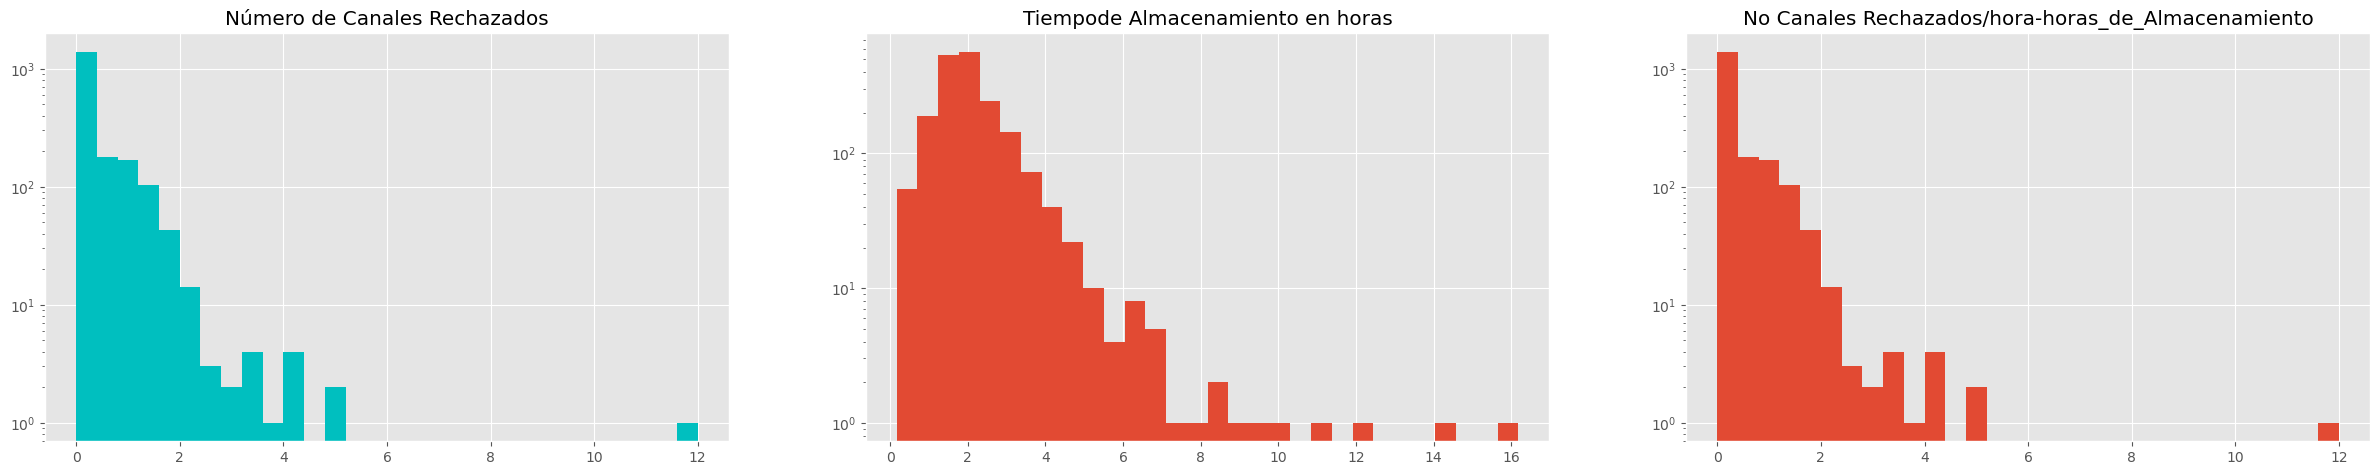

In [29]:
print(
    "Frecuencia Promedio para el almacenamiento = {}".format(np.average(data1["Rechazados"] , weights=data1["Ti1"]))
)

print(
    "Fracción de tiempo de almacenamiento con cero canales Rechazados = {0:.1%}".format(
        data1.loc[data1["Rechazados"] == 0, "Ti1"].sum() / data1["Ti1"].sum()
    )
)

fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=(30, 6))
fig.subplots_adjust(bottom=0.2)
n_bins = 20
ax0.set_title("Número de Canales Rechazados")
_ = data1["Rechazados"].hist(bins=30, log=True, ax=ax0, color = "c")
ax1.set_title("Tiempode Almacenamiento en horas")
_ = data1["Ti1"].hist(bins=30, log=True, ax=ax1)
ax2.set_title("No Canales Rechazados/hora-horas_de_Almacenamiento")
_ = data1["Rechazados"].hist(bins=30, log=True, ax=ax2)

In [30]:
print("Almacenamiento")
data1.isnull().sum() #Datos faltantes
data1['Tamin'].fillna(data1['Tamin'].median(), inplace=True)
print("valores perdidos en Tamin: " + 
      str(data1['Tamin'].isnull().sum()))
data1['Taamax'].fillna(data1['Taamax'].median(), inplace=True)
print("valores perdidos en Taamax: " + 
      str(data1['Taamax'].isnull().sum()))

Almacenamiento
valores perdidos en Tamin: 0
valores perdidos en Taamax: 0


In [31]:
data2 = data1.copy()
data1.columns

Index(['Dia_Semana', 'Temp1', 'Temp2', 'Franja2', 'Ti1', 'Temp3', 'Ti2',
       'Refrigeracion', 'Canales', 'PPPCF', 'pH_Requisito', 'Tamin', 'Taamax',
       'TIPO_CAP_CF', 'Rechazados'],
      dtype='object')

In [32]:
print(data1.groupby("Dia_Semana", dropna=False).agg(Total =("Dia_Semana", "count")),"\n")
print(data1.groupby("Franja2", dropna=False).agg(Total =("Franja2", "count")), "\n")
print(data1.groupby("TIPO_CAP_CF", dropna=False).agg(Total =("TIPO_CAP_CF", "count")))

            Total
Dia_Semana       
jueves        316
lunes         302
martes        324
miércoles     331
sábado        321
viernes       320 

           Total
Franja2         
MADRUGADA     33
MAÑANA       175
MEDIO_DIA    339
NOCHE        505
TARDE        862 

             Total
TIPO_CAP_CF       
C1             187
C2             124
C3            1531
PBA2            72


In [33]:
# el parámetro drop first la primera categoría, para evitar problemas de multicolinealidad
data1 = pd.get_dummies(data1, columns = ["Dia_Semana", "Franja2", "Refrigeracion", "pH_Requisito", "TIPO_CAP_CF"]) 

In [34]:
data1 = data1.drop(["Dia_Semana_lunes","Refrigeracion_GLICOL","pH_Requisito_Mi_6", "Franja2_MADRUGADA", "Franja2_TARDE", "Canales", "TIPO_CAP_CF_PBA2"], axis=1)

### Multicolinealidad

In [35]:
#Multicolinealidad - VIFs
pd.Series([variance_inflation_factor(data1.drop(["Rechazados"], axis=1), i) 
               for i in range((data1.drop(["Rechazados"], axis=1)).shape[1])], 
              index=(data1.drop(["Rechazados"], axis=1)).columns)   

Temp1                       5.660839
Temp2                      16.157239
Ti1                         5.494200
Temp3                       4.304933
Ti2                         8.067628
PPPCF                      13.241525
Tamin                     368.086566
Taamax                    303.648241
Dia_Semana_jueves           2.102020
Dia_Semana_martes           2.109434
Dia_Semana_miércoles        2.116389
Dia_Semana_sábado           2.188424
Dia_Semana_viernes          2.204211
Franja2_MAÑANA              1.272981
Franja2_MEDIO_DIA           1.460244
Franja2_NOCHE               1.644736
Refrigeracion_AMONIACO      3.508776
pH_Requisito_Mi_5.8         4.317868
TIPO_CAP_CF_C1             14.357766
TIPO_CAP_CF_C2              9.058138
TIPO_CAP_CF_C3             82.836420
dtype: float64

In [36]:
data1=data1.drop(["TIPO_CAP_CF_C3", "Taamax", "Tamin"], axis=1)

In [37]:
pd.Series([variance_inflation_factor(data1.drop(["Rechazados"], axis=1), i) 
               for i in range((data1.drop(["Rechazados"], axis=1)).shape[1])], 
              index=(data1.drop(["Rechazados"], axis=1)).columns)   

Temp1                      5.346871
Temp2                     12.642884
Ti1                        4.678640
Temp3                      3.896569
Ti2                        6.690890
PPPCF                      3.974571
Dia_Semana_jueves          1.972674
Dia_Semana_martes          1.978905
Dia_Semana_miércoles       1.973105
Dia_Semana_sábado          2.114335
Dia_Semana_viernes         2.090619
Franja2_MAÑANA             1.240972
Franja2_MEDIO_DIA          1.407564
Franja2_NOCHE              1.591267
Refrigeracion_AMONIACO     3.100429
pH_Requisito_Mi_5.8        3.874932
TIPO_CAP_CF_C1             1.422044
TIPO_CAP_CF_C2             1.247212
dtype: float64

# Una línea base de predicción constante

Vale la pena señalar que el  69,4% de los canales de res analizados no se rechaza por no cumplir con las condiciones de calidad. 

Para evaluar la pertinencia de las métricas utilizadas, consideraremos como línea base un estimador “dummy” que predice constantemente la frecuencia media de la muestra de entrenamiento.

In [38]:
from sklearn.dummy import DummyRegressor
X_train, X_test, y_train, y_test = train_test_split(data1.drop(["Rechazados"], axis=1), data1["Rechazados"], 
                                                    test_size=0.2, random_state=0)

Calculemos el rendimiento de esta línea base de predicción constante con 2 métricas de regresión diferentes. Primero para 

In [39]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

def score_estimator(estimator, X_test):
    """Score an estimator on the test set."""
    y_pred = estimator.predict(X_test)

    print(
        "MSE: %.3f"
        % mean_squared_error(
           y_test, y_pred, sample_weight=X_test["Ti1"],squared=True
        )
    )
    print(
        "MAE: %.3f"
        % mean_absolute_error(
           y_test, y_pred, sample_weight=X_test["Ti1"]
        )
    )   

# Dummy Regressor

In [40]:
dummy_mod = DummyRegressor(strategy="median")
dummy_mod.fit(X_train, y_train, sample_weight = X_train["Ti1"],)
print("Evaluación de la Frecuencia Media Constante:")
score_estimator(dummy_mod, X_test)

Evaluación de la Frecuencia Media Constante:
MSE: 0.259
MAE: 0.225


# K-Nearest Neighbor (kNN)

In [41]:
from sklearn.neighbors import KNeighborsRegressor
print("knn evaluation:")
knn = KNeighborsRegressor(n_neighbors = 27)
knn_mod = knn.fit(X_train, y_train)
score_estimator(knn_mod, X_test)

knn evaluation:
MSE: 0.212
MAE: 0.347


# Modelos Lineales (Generalizados) - MLG

Comenzamos modelando la variable objetivo con el modelo de regresión lineal de mínimos cuadrados (penalizado por l2), más comúnmente conocido como regresión de Ridge. 

La desviación de Poisson no se puede calcular en valores no positivos predichos por el modelo. Para los modelos que arrojan algunas predicciones no positivas (por ejemplo, Ridge), ignoramos las muestras correspondientes, lo que significa que la desviación de Poisson obtenida es aproximada. Un enfoque alternativo podría ser usar TransformedTargetRegressor un metaestimador para mapear y_preda un dominio estrictamente positivo.

In [42]:
from sklearn.linear_model import Ridge
ridge_glm =  Ridge(alpha=0.01)
ridge_glm .fit(X_train, y_train, sample_weight = X_train["Ti1"])

print("Ridge evaluation:")
score_estimator(ridge_glm, X_test)

Ridge evaluation:
MSE: 0.202
MAE: 0.344


A continuación ajustamos el regresor de Poisson en la variable objetivo. Establecemos la fuerza de regularización alphaen aproximadamente 0.01 sobre el número de muestras (es decir, 0.01) para imitar el regresor de Ridge cuyo término de penalización L2 se escala de manera diferente con el número de muestras.

Dado que el regresor de Poisson modela internamente el logaritmo del valor objetivo esperado en lugar del valor esperado directamente (logaritmo frente a la función de enlace de identidad), la relación entre X e y ya no es exactamente lineal. Por lo tanto, el regresor de Poisson se denomina modelo lineal generalizado (GLM) en lugar de un modelo lineal estándar como es el caso de la regresión de Ridge.

# Poisson

In [43]:
from sklearn.linear_model import PoissonRegressor
Poisson_glm =   PoissonRegressor(alpha=0.1)
Poisson_glm.fit(X_train, y_train, sample_weight = X_train["Ti1"])

print("PoissonRegressor evaluation - Almacenamiento:")
score_estimator(Poisson_glm, X_test)


PoissonRegressor evaluation - Almacenamiento:
MSE: 0.205
MAE: 0.344


# Random Forest

In [44]:
from sklearn.ensemble import RandomForestRegressor
rf =   RandomForestRegressor(n_estimators=2000, max_features=7, max_depth=20)
rf.fit(X_train, y_train, sample_weight = X_train["Ti1"])

print("RandomForestRegressor evaluation - Almacenamiento:")
score_estimator(rf, X_test)

RandomForestRegressor evaluation - Almacenamiento:
MSE: 0.199
MAE: 0.318


# Árboles de regresión de aumento de gradiente para la regresión de Poisson 

Finalmente, consideraremos un modelo no lineal, llamado Gradient Boost Regression Trees. Este brinda la posibilidad de ajustar los árboles con una pérdida de Poisson (con una función de enlace de registro implícita) en lugar de la pérdida por mínimos cuadrados predeterminada. Aquí solo ajustamos árboles con la pérdida de Poisson para mantener este ejemplo conciso

In [45]:
from sklearn.ensemble import HistGradientBoostingRegressor

HGB =  HistGradientBoostingRegressor(loss="poisson",  max_leaf_nodes=128)
HGB.fit(X_train, y_train, sample_weight = X_train["Ti1"])

print("Para el Alamacenamiento las métricas son:")
print("Poisson Gradient Boosted Trees evaluation:")
score_estimator(HGB, X_test)

Para el Alamacenamiento las métricas son:
Poisson Gradient Boosted Trees evaluation:
MSE: 0.199
MAE: 0.259


El modelo de árboles potenciados por gradiente minimiza la desviación de Poisson. Sin embargo, debido a su mayor poder predictivo, alcanza valores más bajos de desviación de Poisson.

La evaluación de modelos con una sola división de tren/prueba es propensa a fluctuaciones aleatorias. Si los recursos informáticos lo permiten, se debe verificar que las métricas de rendimiento con validación cruzada lleven a conclusiones similares.

In [46]:
for mod in [dummy_mod, knn, ridge_glm, Poisson_glm, rf, HGB]:
    print(f"Metricas para{mod}:")
    score_estimator(mod, X_test)
    

Metricas paraDummyRegressor(strategy='median'):
MSE: 0.259
MAE: 0.225
Metricas paraKNeighborsRegressor(n_neighbors=27):
MSE: 0.212
MAE: 0.347
Metricas paraRidge(alpha=0.01):
MSE: 0.202
MAE: 0.344
Metricas paraPoissonRegressor(alpha=0.1):
MSE: 0.205
MAE: 0.344
Metricas paraRandomForestRegressor(max_depth=20, max_features=7, n_estimators=2000):
MSE: 0.199
MAE: 0.318
Metricas paraHistGradientBoostingRegressor(loss='poisson', max_leaf_nodes=128):
MSE: 0.199
MAE: 0.259



# Comparación Gráfica

## Almacenamiento

Número de Canales Rechazados en Registros: 183.0
Número de Canales Rechazados Predecidos por DummyRegressor(strategy='median'): 0.0
Número de Canales Rechazados Predecidos por KNeighborsRegressor(n_neighbors=27): 243.8
Número de Canales Rechazados Predecidos por Ridge(alpha=0.01): 228.5
Número de Canales Rechazados Predecidos por PoissonRegressor(alpha=0.1): 224.3
Número de Canales Rechazados Predecidos por RandomForestRegressor(max_depth=20, max_features=7, n_estimators=2000): 243.2
Número de Canales Rechazados Predecidos por HistGradientBoostingRegressor(loss='poisson', max_leaf_nodes=128): 140.5


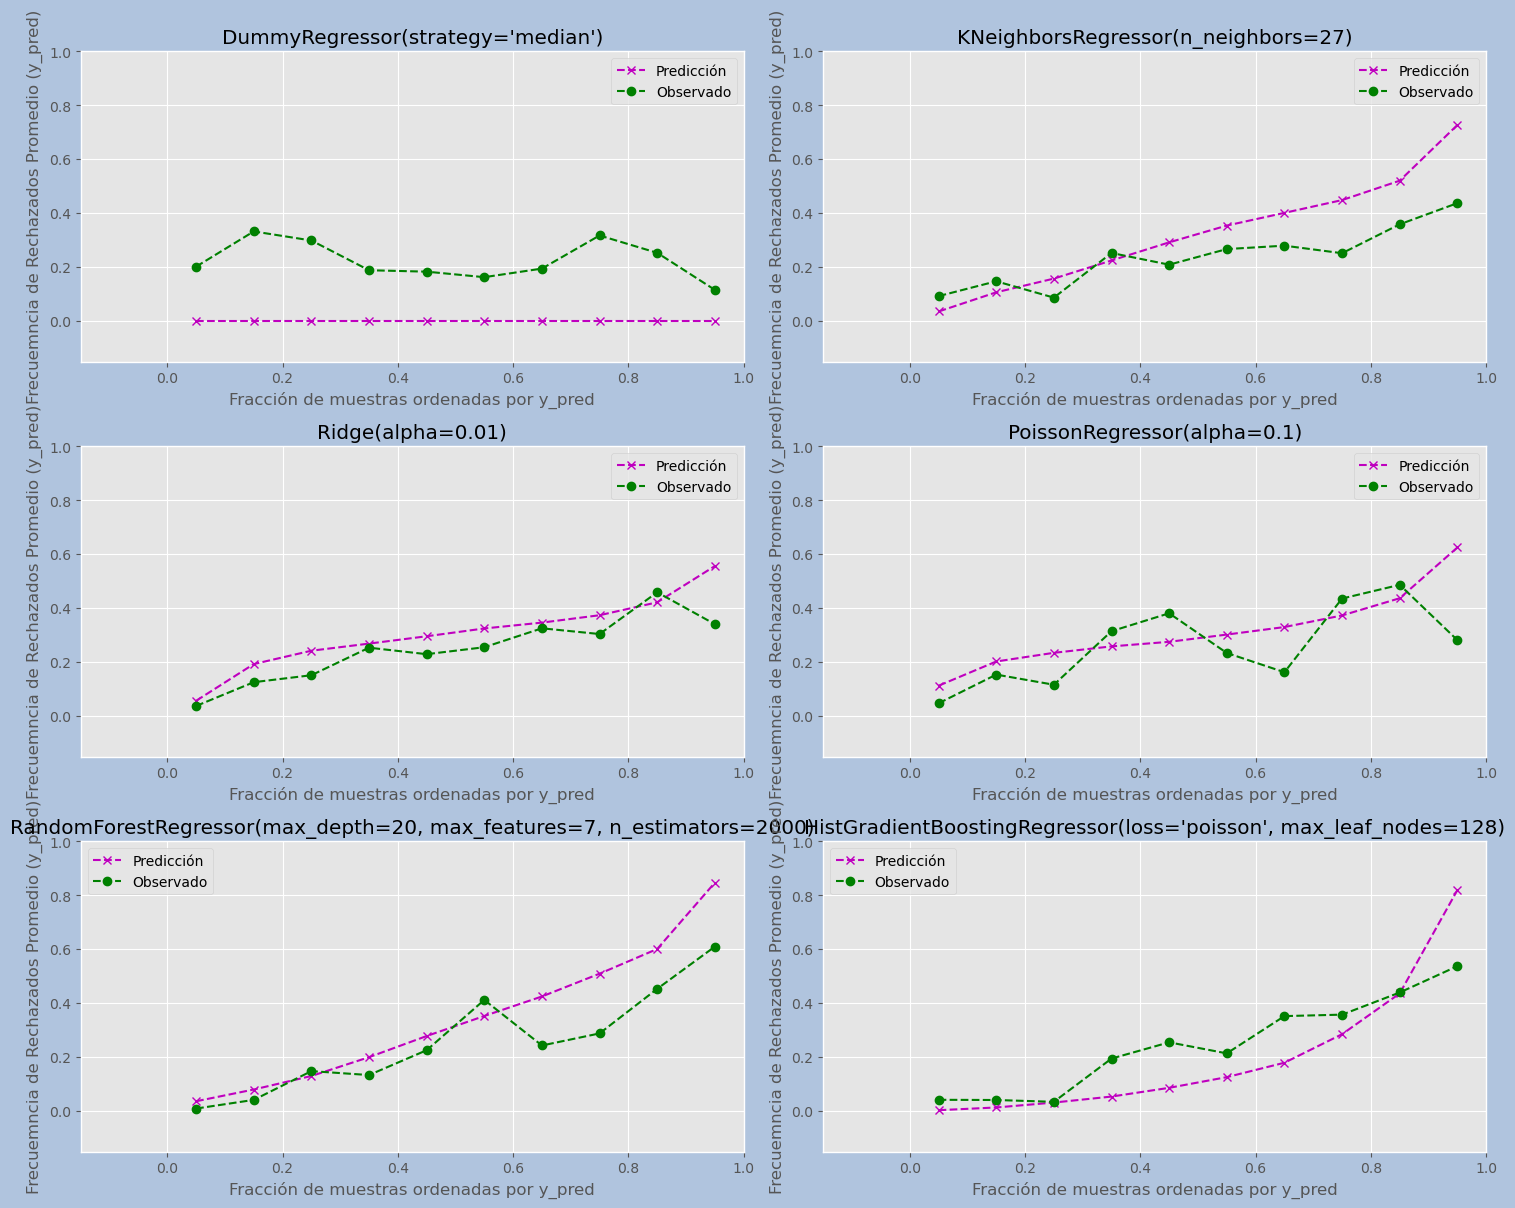

In [47]:
from sklearn.utils import gen_even_slices

def _mean_frequency_by_risk_group(y_true, y_pred, sample_weight=None, n_bins=100):

    idx_sort = np.argsort(y_pred) ###Matriz con los indices de l0 que se predijo anteriomente
    bin_centers = np.arange(0, 1, 1 / n_bins) + 0.5 / n_bins
    y_pred_bin = np.zeros(n_bins)
    y_true_bin = np.zeros(n_bins)

    for n, sl in enumerate(gen_even_slices(len(y_true), n_bins)):
        weights = sample_weight[idx_sort][sl]
        y_pred_bin[n] = np.average(y_pred[idx_sort][sl], weights=weights)
        y_true_bin[n] = np.average(y_true[idx_sort][sl], weights=weights)
    return bin_centers, y_true_bin, y_pred_bin


print(f"Número de Canales Rechazados en Registros: {np.sum(y_test * X_test.Ti1)}")
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(15, 12), facecolor = "#B0C4DE")
plt.subplots_adjust(wspace=0.1)

for axi, model in zip(ax.ravel(), [dummy_mod, knn, ridge_glm, Poisson_glm, rf, HGB]):
    y_pred = model.predict(X_test)
    y_true = y_test.values
    Ti1 = X_test["Ti1"].values
    q, y_true_seg, y_pred_seg = _mean_frequency_by_risk_group(
        y_true, y_pred, sample_weight=Ti1, n_bins=10
    )
  
    # Name of the model after the estimator used in the last step of the
    # pipeline.
    print(f"Número de Canales Rechazados Predecidos por {model}: {np.sum(y_pred * Ti1):.1f}")
    axi.plot(q, y_pred_seg, marker="x", linestyle="--", label = "Predicción", color = "m")
    axi.plot(q, y_true_seg, marker="o", linestyle="--", label="Observado", color = 	"g")
    axi.set_xlim(-0.15, 1.0)
    axi.set_ylim(-0.15, 1)
    axi.set(     
        title=model,  
        xlabel="Fracción de muestras ordenadas por y_pred",
        ylabel="Frecuemncia de Rechazados Promedio (y_pred)",
    )
    axi.legend()
plt.tight_layout()

# Evaluación del poder de clasificación 

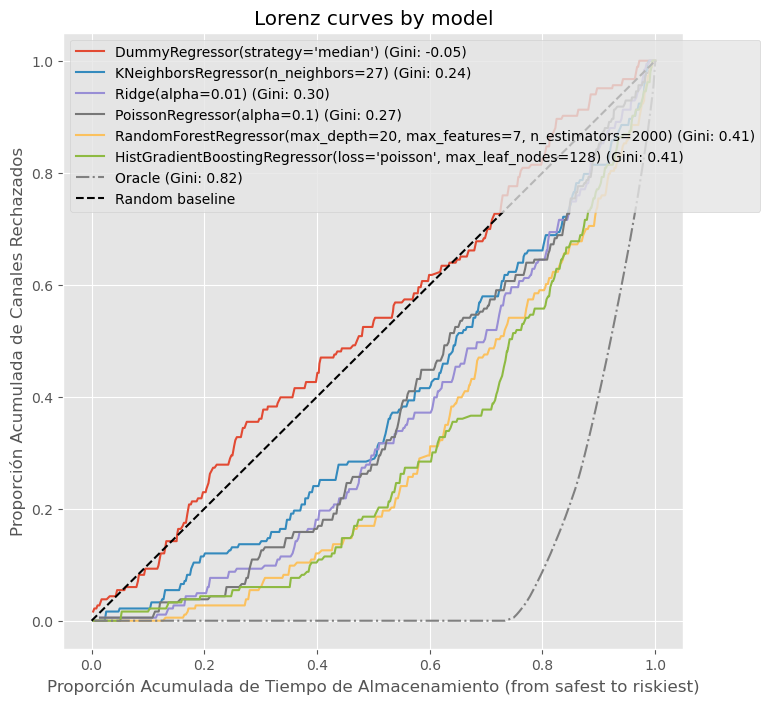

In [48]:
from sklearn.metrics import auc


def lorenz_curve(y_true, y_pred, Ti1):
    y_true, y_pred = np.asarray(y_true), np.asarray(y_pred)
    Ti1 = np.asarray(Ti1)

    # order samples by increasing predicted risk:
    ranking = np.argsort(y_pred)
    ranked_frequencies = y_true[ranking]
    ranked_Ti1 = Ti1[ranking]
    cumulated_Rechazados= np.cumsum(ranked_frequencies * ranked_Ti1)
    cumulated_Rechazados /= cumulated_Rechazados[-1]
    cumulated_Ti1 = np.cumsum(ranked_Ti1)
    cumulated_Ti1/= cumulated_Ti1[-1]
    return cumulated_Ti1, cumulated_Rechazados


fig, ax = plt.subplots(figsize=(8, 8))
for model in [dummy_mod, knn, ridge_glm, Poisson_glm, rf, HGB]:
    y_pred = model.predict(X_test)
    cum_Ti1, cum_Rechazados = lorenz_curve(
    y_test, y_pred, X_test["Ti1"]
    )
    gini = 1 - 2 * auc(cum_Ti1, cum_Rechazados)
    label = "{} (Gini: {:.2f})".format(model, gini)
    ax.plot(cum_Ti1, cum_Rechazados, linestyle="-", label=label)

# Oracle model: y_pred == y_test
    cum_Ti1, cum_Rechazados = lorenz_curve(
    y_test,y_test, X_test["Ti1"]
)
    gini = 1 - 2 * auc(cum_Ti1, cum_Rechazados)
    label = "Oracle (Gini: {:.2f})".format(gini)
ax.plot(cum_Ti1, cum_Rechazados, linestyle="-.", color="gray", label=label)
# Random Baseline
ax.plot([0, 1], [0, 1], linestyle="--", color="black", label="Random baseline")
ax.set(
    title="Lorenz curves by model",
    xlabel="Proporción Acumulada de Tiempo de Almacenamiento (from safest to riskiest)",
    ylabel="Proporción Acumulada de Canales Rechazados",
)
ax.legend(loc="upper left")
